# Prepare dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['font.size'] = 20

### Prepare components

In [2]:
# configuration
components = [{
    'n_samples': 50,
    'center': (2.8, 5.5),
    'cluster_std': 0.2
}, {
    'n_samples': 200,
    'center': (3.0, 5.5),
    'cluster_std': 1.3
}, {
    'n_samples': 300,
    'center': (2.5, 2.3),
    'cluster_std': 0.8
}, {
    'n_samples': 1000,
    'center': (5.0, 2.3),
    'cluster_std': 1.0
}]

In [3]:
n_samples = []
centers = []
cluster_stds = []

for component in components:
    n_samples.append(component['n_samples'])
    centers.append(component['center'])
    cluster_stds.append(component['cluster_std'])

In [4]:
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:red'][:len(components)])

def plot_components(X, y, cmap, title='Dataset', scaled=False, save=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=18)

    plt.title(title)
    plt.tight_layout()
    if scaled:
        plt.axis('scaled')
    if save is not None:
        plt.savefig(save)
    plt.show()

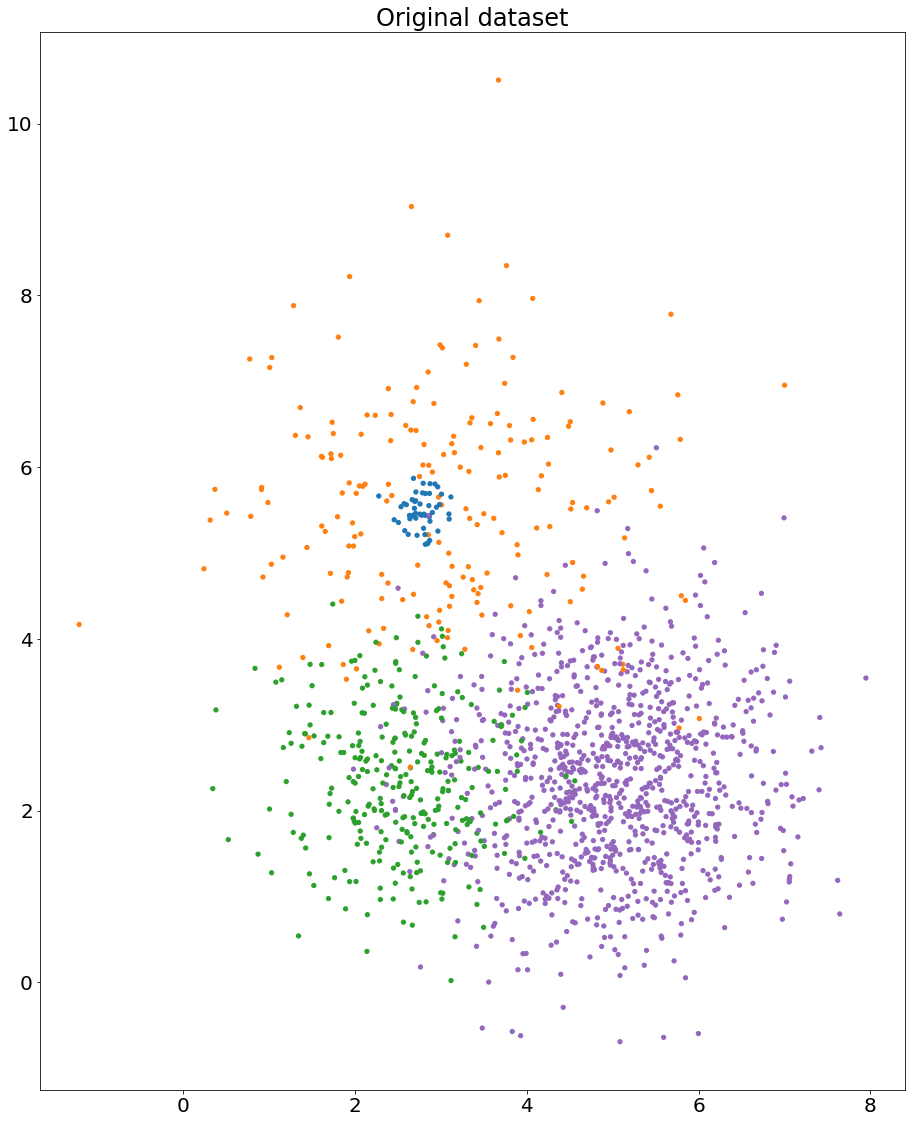

In [5]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_stds, shuffle=True, random_state=42)

plot_components(X, y, my_cmap, 'Original dataset', scaled=True, save='plots/components.jpg')

### Transform the data to be more irregular

In [6]:
import numpy as np

# configuration
x_mult = 7
y_mult = 1
rotation = np.pi / 6

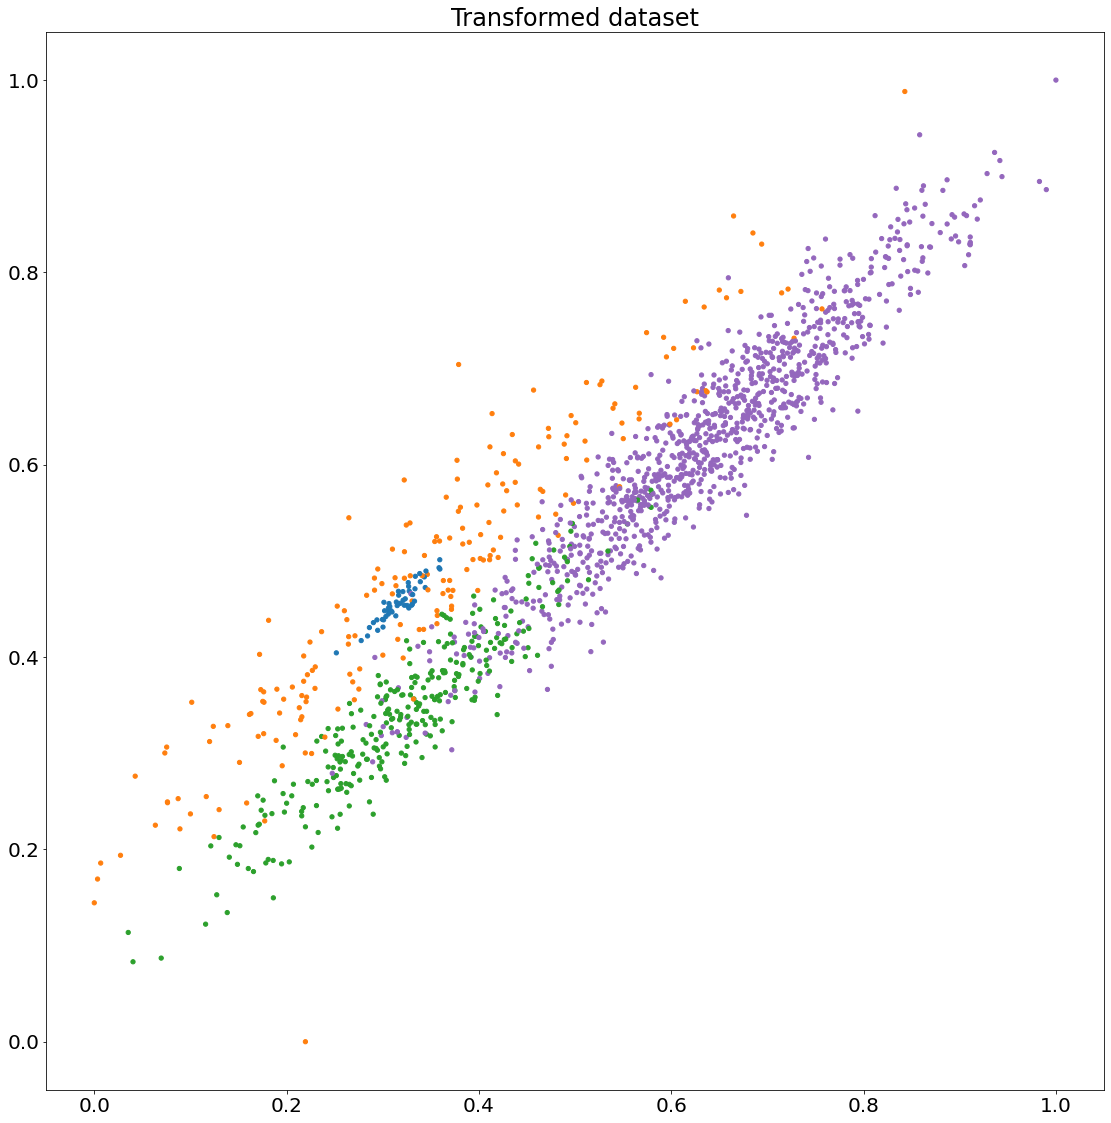

In [7]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

class IrregularTransformer(TransformerMixin):
    
    def __init__(self, x_mult, y_mult):
        self.x_mult = x_mult
        self.y_mult = y_mult    
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = np.empty(shape=X.shape)
        X_new[:, 0] = X[:, 0] * x_mult
        X_new[:, 1] = X[:, 1] * y_mult
        radii = np.sqrt(np.sum(np.square(X_new), axis=1))
        angles = np.arctan(X_new[:, 1] / X_new[:, 0])
        angles = angles + rotation
        X_new[:,0] = np.cos(angles) * radii
        X_new[:,1] = np.sin(angles) * radii
        return X_new

pipeline = Pipeline([
    ('irregular_transformer', IrregularTransformer(x_mult, y_mult)),
    ('scaler', MinMaxScaler())
])

X_new = pipeline.fit_transform(X)

plot_components(X_new, y, my_cmap, 'Transformed dataset', scaled=True, save='plots/irregular.jpg')

X_data = X_new
y_data = y

# Exercise 1

In [8]:
from sklearn.neighbors import DistanceMetric

X = X_data
y = y_data

# configuration
n_neighbors = [1, 13, 1, 9]
weights = ['uniform', 'uniform', 'uniform', 'distance']
metric = ['euclidean', 'euclidean', 'mahalanobis', 'euclidean']
metric_params = [{}, {}, {'V': np.cov(X.T)}, {}]

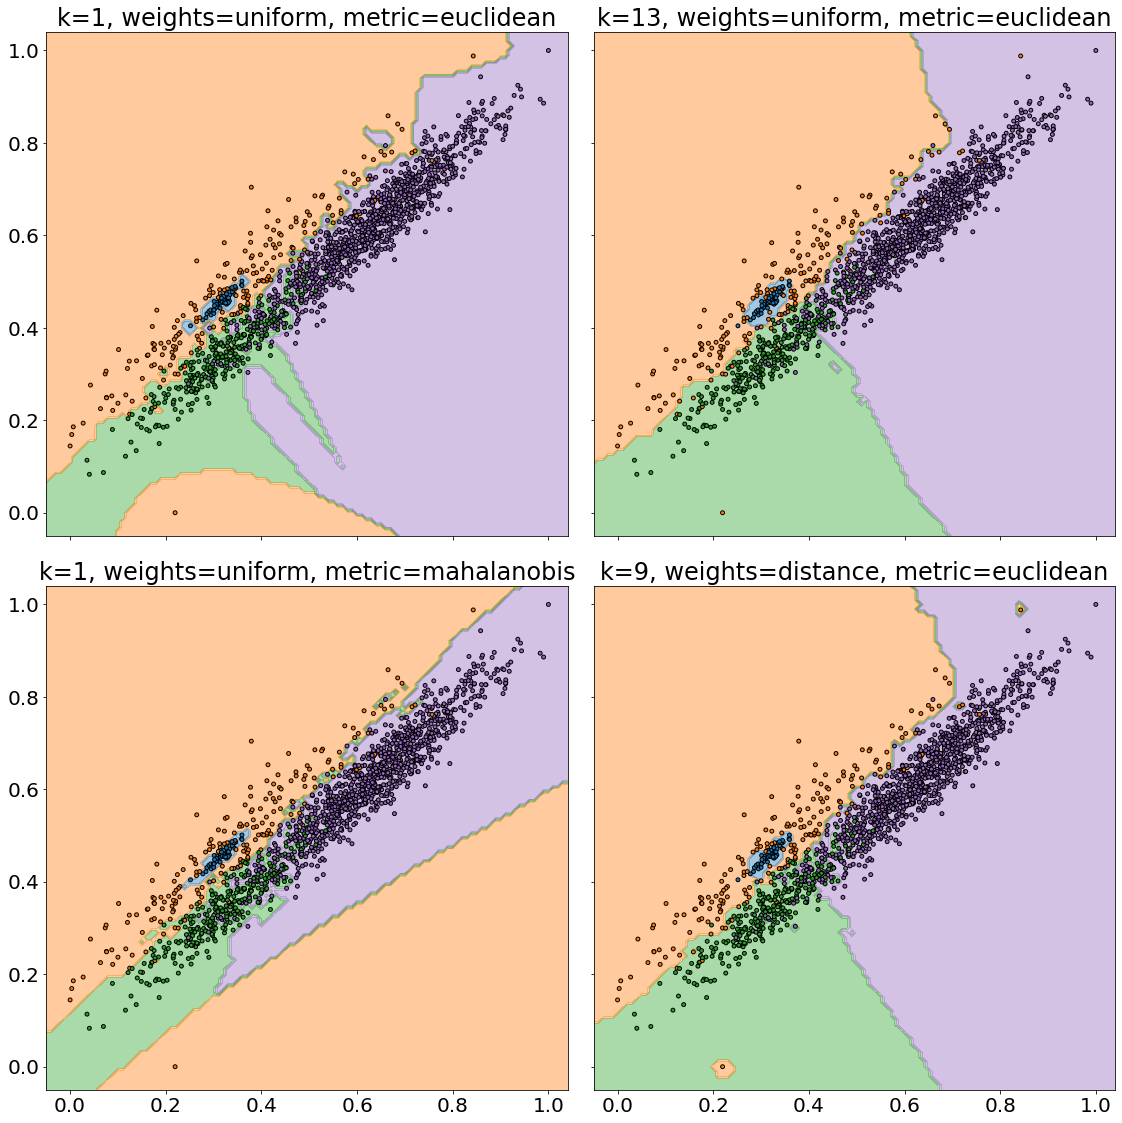

In [9]:
from sklearn.neighbors import KNeighborsClassifier

h = 0.01
x_min, x_max = X[:, 0].min() - .05, X[:, 0].max() + .05
x_min, x_max = X[:, 1].min() - .05, X[:, 1].max() + .05

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(x_min, x_max, h))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row')

for i in range(len(n_neighbors)):  
    neighbors_model = KNeighborsClassifier(n_neighbors=n_neighbors[i],
                                           weights=weights[i],
                                           metric=metric[i],
                                           metric_params=metric_params[i])
    
    neighbors_model.fit(X, y)
    Z = neighbors_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    row = i // 2
    col = i % 2
    axarr[row, col].contourf(xx, yy, Z, cmap=my_cmap, alpha=0.4)
    axarr[row, col].scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap, s=15, edgecolor='k')
    axarr[row, col].set_title(f'k={n_neighbors[i]}, weights={weights[i]}, metric={metric[i]}')
    
plt.tight_layout()
plt.savefig('plots/exercise1.jpg')
plt.show()

# Exercise 2

In [10]:
# configuration
k_start, k_end = 1, 20
n_models = 4
n_test = 10
n_validation = 20

weights = ['uniform', 'uniform', 'distance', 'distance'][:n_models]
metric = ['mahalanobis', 'euclidean', 'mahalanobis', 'euclidean'][:n_models]
metric_params = [{'V': np.cov(X.T)}, {}, {'V': np.cov(X.T)}, {}][:n_models]

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

def test_neighbors_in_range(X, y, k_range, weights, metric, metric_params, validate_split):
    means, stds = [], []
    for k in k_range:   
        neighbors_model = KNeighborsClassifier(n_neighbors=k,
                                               weights=weights,
                                               metric=metric,
                                               metric_params=metric_params)
        
        scores = []
        for train_index, test_index in validate_split.split(X, y):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

            neighbors_model.fit(X_train, y_train)
            y_predicted = neighbors_model.predict(X_test)
            scores.append(accuracy_score(y_predicted, y_test))

        scores = np.array(scores)
        mean = scores.mean()
        std = scores.std()
        means.append(mean)
        stds.append(std)
        # print(f'{k}:', k_mean, '+-', k_std)
        
    return np.array(means), np.array(stds)


def test_neighbors(X, y, n_test, n_validation, k_start, k_end, weights, metric, metric_params):
    mean, std = [], []
    
    test_split = StratifiedShuffleSplit(n_splits=n_test, test_size=0.2, random_state=42)
    validate_split = StratifiedShuffleSplit(n_splits=n_validation, test_size=0.2, random_state=43)
    
    # many iterations
    scores = []
    for i, (train_index, test_index) in enumerate(test_split.split(X, y)):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        # find best k
        mean, std = test_neighbors_in_range(X_train, y_train, range(k_start, k_end + 1), weights, metric, 
                                            metric_params, validate_split)
        idx_best = mean.argmax()
        k_best = k_start + idx_best
        
        # test best k
        neighbors_model = KNeighborsClassifier(n_neighbors=k_best,
                                               weights=weights,
                                               metric=metric,
                                               metric_params=metric_params)
        neighbors_model.fit(X_train, y_train)
        y_predicted = neighbors_model.predict(X_test)
        score = accuracy_score(y_predicted, y_test)
        scores.append(score)
        print(f'iter: {i:2}, SCORE: {score:.6f}, best k: {k_best:2} -- mean: {mean[idx_best]:.6f} +- {std[idx_best]:.6f}')
        
    scores = np.array(scores)
    mean = scores.mean()
    std = scores.std()
    return mean, std
    

def test_many_neighbors(X, y, n_test, n_validation, k_start, k_end, weights, metric, metric_params):
    means, stds = [], []
    for iter_weights, iter_metric, iter_metric_params in zip(weights, metric, metric_params):
        print(f'weights: {iter_weights}, metric: {iter_metric}')
        mean, std = test_neighbors(X, y, n_test, n_validation, k_start, k_end, iter_weights, 
                                   iter_metric, iter_metric_params)
        means.append(mean)
        stds.append(std)
        print(f'mean: {mean:.6f} +- {std:.6f}')
        print('=========================================')
        
    means = np.array(means)
    best_idx = means.argmax()
    print(f'BEST: weights: {weights[best_idx]}, metric: {metric[best_idx]} -- \
mean_score: {means[best_idx]} +- {stds[best_idx]}')

test_many_neighbors(X_data, y_data, n_test, n_validation, k_start, k_end, weights, metric, metric_params)

weights: uniform, metric: mahalanobis
iter:  0, SCORE: 0.900000, best k: 19 -- mean: 0.903629 +- 0.017847
iter:  1, SCORE: 0.890323, best k: 19 -- mean: 0.901210 +- 0.014843
iter:  2, SCORE: 0.903226, best k: 19 -- mean: 0.900806 +- 0.017595
iter:  3, SCORE: 0.877419, best k: 17 -- mean: 0.907056 +- 0.013096
iter:  4, SCORE: 0.896774, best k: 16 -- mean: 0.895968 +- 0.018896
iter:  5, SCORE: 0.900000, best k: 17 -- mean: 0.903629 +- 0.015870
iter:  6, SCORE: 0.903226, best k: 14 -- mean: 0.889315 +- 0.013643
iter:  7, SCORE: 0.883871, best k: 15 -- mean: 0.903226 +- 0.014815
iter:  8, SCORE: 0.887097, best k: 18 -- mean: 0.909274 +- 0.013159
iter:  9, SCORE: 0.883871, best k: 18 -- mean: 0.903226 +- 0.014925
mean: 0.892581 +- 0.008781
weights: uniform, metric: euclidean
iter:  0, SCORE: 0.893548, best k:  8 -- mean: 0.895565 +- 0.014364
iter:  1, SCORE: 0.893548, best k:  3 -- mean: 0.888911 +- 0.018233
iter:  2, SCORE: 0.890323, best k:  6 -- mean: 0.890927 +- 0.019691
iter:  3, SCORE